In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import argparse
import sys

## Load Data and Calc Functions

In [2]:
def load_data(filepath):
    """    
    Parameters:
    filepath (cvs): training data.

    Returns:
    x (np.array) : inputs, attributes.
    y (np.array) : outputs.

    """
    X, y = [], []
    with open(filepath, 'r') as file:
        for line in file:
            x, y_ = line.strip().split(',')
            X.append(float(x))
            y.append(float(y_))
    return np.array(X), np.array(y)


def load_sol_data(filepath):
    """    
    Parameters:
    filepath (cvs): solution data.

    Returns:
    m (int) : polynomial degree.
    w (np.array) : weights.

    """
    with open(filepath, 'r') as file:
        m = int(file.readline().strip())
        w = []
        for line in file:
            w_ = float(line.strip())
            w.append(w_)
    return m, np.array(w)



def create_phi(x, degree):
    """
    This function creates a matrix of x values raised to powers.
    :param x: numpy array of input data
    :param degree: degree of the polynomial
    :return: matrix of x values raised to powers
    """
    matrix = np.zeros((len(x), degree + 1))
    for i in range(len(x)):
        for j in range(degree + 1):
            matrix[i][j] = x[i] ** j
    return matrix


def regularized_linear_regression(phi, t, lambda_):
    """
    Find the best fitting regularized weights for a linear model using equation 3.28 from PRML.

    Parameters:
    X : Training data input. (trainPath)
    y : Training data output. (modelOutput)
    lambda_ : Regularization parameter.

    Returns:
    w : Best regularized weights.
    """
    i, size = phi.shape
    phi_t = phi.transpose()
    phit_phi = np.matmul(phi_t, phi)
    id = np.identity(size)
    phit_phi += lambda_ * id
    phit_phi_inv = np.linalg.inv(phit_phi)
    w_reg = np.matmul(phit_phi_inv, phi_t)
    w = np.matmul(w_reg, t)
    return w


def sweep(X, m, lambda_):
    """
    Sweep up to max polynomial (m).

    Parameters:
    X : Training data input. (trainPath)
    m : Given polynomial.
    lambda_ : Regularization parameter.

    Returns:
    weight_list : List of best regularized weights per polynomial.
    """
    weight_list = []
    for i in range(m+1):
        phi_m = create_phi(X, i)
        weight = regularized_linear_regression(phi_m, t, 0)
        weight_list.append(weight)
    return weight_list


def prediction(X, phi, w):
    """
    Compute prediction for polynomial regression.

    Parameters:
    X (np.array) : Training data input.
    phi (matrix) : Matrix of x values raised to powers.
    w (np.array) : Best regularized weights.

    Returns:
    y(X, phi, w) : prediction.
    """

    return np.dot(phi, w)


def small_phi(phi, r):
    return phi[r]


def errorfunction(y, t):
    error = 0.0
    for i in range(len(y)):
        error += (y[i]-t[i])**2

    return 1/2*error

def split_data(x, t, ratio):
    # Shuffle data
    shuffle_index = np.random.permutation(len(x))
    x = x[shuffle_index]
    t = t[shuffle_index]
    
    # Split data into training and test sets
    split_index = int(len(x) * ratio)
    x_train = x[:split_index]
    t_train = t[:split_index]
    x_test = x[split_index:]
    t_test = t[split_index:]
    
    return x_train, t_train, x_test, t_test

def rms(error, N):
    return np.sqrt((2*error)/N)


## Curve Fitting without k-fold validation

In [ ]:
# def kfold_cv(data, k):
#     data_split = []
#     fold_size = int(len(data) / k)
#     for i in range(k):
#         lower_bound = i * fold_size
#         upper_bound = (i + 1) * fold_size
#         if i == k-1:
#             upper_bound = len(data)
#         fold = data[lower_bound:upper_bound]
#         data_split.append(fold)
#     return data_split

def solve_curve_fitting(x, t, M):
    phi = np.array(create_phi(x, M))
    w = regularized_linear_regression(phi, t, 0.0)
    y = prediction(x, phi, w)    
    error = errorfunction(y, t)
    rms = np.sqrt(2*error/len(x))
    
    return w, y, error, rms
    # return rms


def split_data(x, t, ratio):
    # Shuffle data
    shuffle_index = np.random.permutation(len(x))
    x = x[shuffle_index]
    t = t[shuffle_index]
    
    # Split data into training and test sets
    split_index = int(len(x) * ratio)
    x_train = x[:split_index]
    t_train = t[:split_index]
    x_test = x[split_index:]
    t_test = t[split_index:]
    
    return x_train, t_train, x_test, t_test

def plot_tt(x, t, m, ratio):
    
    x_train, t_train, x_test, t_test = split_data(x, t, ratio)
    M = np.arange(0, m)
    train_rms = []
    test_rms = []
    for i in M:
        rms_train = solve_curve_fitting(x_train, t_train, i)
        train_rms.append(rms_train[3])
        rms_test = solve_curve_fitting(x_test, t_test, i)
        test_rms.append(rms_test[3])
        
    plt.plot(M, train_rms, '-o', label='Train RMS')
    plt.plot(M, test_rms, '-o', label='Test RMS')
    plt.xlabel('M (degree)')
    plt.ylabel('RMS')
    plt.legend()
    plt.show()





In [ ]:
input = load_data("sampleData/X")
X, t = input
M =30
k = 5

In [ ]:

fit = solve_curve_fitting(X, t, M)
w = fit[0]
y = fit[1]
error = fit[2]
rms = fit[3]

plt.plot(X, t, 'o', label='Target')
plt.plot(X, y, '-', label='Prediction')
plt.legend()
plt.title('MSE: {:.2f}'.format(error) + ' and K_RMS: {:.2f}'.format(rms))
plt.show()

    
print('Coefficients:', w)
# print('Predicted values:', y)
print('Mean Squared Error:', error)
print('Root-Mean-Squared:', rms)

In [ ]:
ratio = 7/10
plot_tt(X, t, M, ratio)


## Curve Fitting with k-fold validation #1

In [39]:
def kfold_cv_k(x, t, M, k):
    """
    K-Fold Cross Validation
    
    Parameters:
    x (np.array): inputs, attributes.
    t (np.array): outputs.
    M (int): polynomial degree.
    k (int): number of folds.
    
    Returns:
    avg_error (float): average root mean squared error.
    """
    data = np.concatenate((x.reshape(-1,1), t.reshape(-1,1)), axis=1)
    folds = np.array_split(data, k)
    error_list = []
    for i in range(k):
        validation_fold = folds[i]
        training_folds = np.concatenate([folds[j] for j in range(k) if j != i])
        x_train, t_train = training_folds[:,0], training_folds[:,1]
        x_val, t_val = validation_fold[:,0], validation_fold[:,1]
        phi_train = create_phi(x_train, M)
        w_train = regularized_linear_regression(phi_train, t_train, 0)
        y_test = prediction(x_train, create_phi(x_train, M), w_train)
        error = errorfunction(y_test, t_train)
        error_list.append(error)
    avg_error = np.mean(error_list)
    return avg_error


def solve_curve_fitting_k(x, t, M, k):

    phi = np.array(create_phi(x, M))
    w = regularized_linear_regression(phi, t, 0.0)
    y = prediction(x, phi, w)    
    error = errorfunction(y, t)
    rms = np.sqrt(2*error/len(x))
    avg_error = kfold_cv_k(x, t, M, k)
    k_rms = np.sqrt(2*avg_error/len(x))

    return w, y, error, rms, avg_error, k_rms
    # return rms

def plot_tt_k(x, t, m, ratio, k):
    x_train, t_train, x_test, t_test = split_data(x, t, ratio)
    M = np.arange(0, m)
    train_rms = []
    test_rms = []
    for i in M:
        rms_train = solve_curve_fitting_k(x_train, t_train, i, k)
        train_rms.append(rms_train[5])
        rms_test = solve_curve_fitting_k(x_test, t_test, i, k)
        test_rms.append(rms_test[5])
        
    plt.plot(M, train_rms, '-o', label='Train RMS')
    plt.plot(M, test_rms, '-o', label='Test RMS')
    plt.xlabel('M (degree)')
    plt.ylabel('RMS')
    plt.legend()
    plt.show()

In [65]:
input = load_data("sampleData/X")
X, t = input
M =25
k = 5
ratio = 8/10
fit = solve_curve_fitting_k(X, t, M,k)
w = fit[0]
y = fit[1]
error = fit[2]
rms = fit[3]
avg_error = fit[4]
k_rms = fit[5]

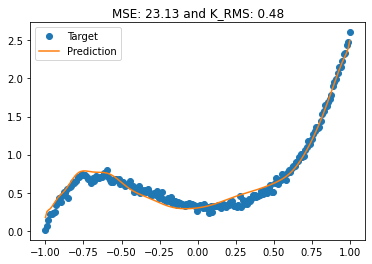

Coefficients: [ 2.99963014e-01  2.64134274e-01  1.60437742e+00  1.22148642e+00
  1.00843375e+01 -1.02070682e+02 -1.55334444e+02  1.35359274e+03
  2.82990771e+02 -8.42775399e+03  5.87161679e+03  2.65299829e+04
 -4.65707100e+04 -3.20153709e+04  1.64840515e+05 -4.93057488e+04
 -3.36891398e+05  2.43691422e+05  4.21587412e+05 -4.00621703e+05
 -3.19416952e+05  3.47799411e+05  1.34785819e+05 -1.59336788e+05
 -2.43446114e+04  3.04347024e+04]
Mean Squared Error: 23.13178622692336
Root-Mean-Squared: 0.48095515619362433


In [66]:
plt.plot(X, t, 'o', label='Target')
plt.plot(X, y, '-', label='Prediction')
plt.legend()
plt.title('MSE: {:.2f}'.format(avg_error) + ' and K_RMS: {:.2f}'.format(k_rms))
plt.show()

    
print('Coefficients:', w)
# print('Predicted values:', y)
print('Mean Squared Error:', avg_error)
print('Root-Mean-Squared:', k_rms)

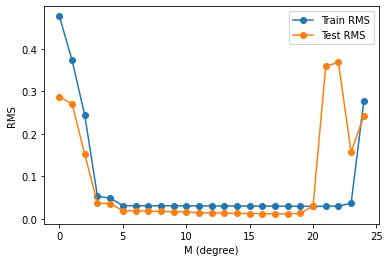

In [68]:
plot_tt_k(X, t, M, ratio,k)


## Curve Fitting with k-fold validation #2

In [ ]:
# def kfold_cv_2(data, k):
#     data_split = []
#     fold_size = int(len(data) / k)
#     for i in range(k):
#         lower_bound = i * fold_size
#         upper_bound = (i + 1) * fold_size
#         if i == k-1:
#             upper_bound = len(data)
#         fold = data[lower_bound:upper_bound]
#         data_split.append(fold)
#     return data_split

def solve_curve_fitting_k_2(x, t, M, k, ratio):
    phi = np.array(create_phi(x, M))
    w = regularized_linear_regression(phi, t, 0.0)
    y = prediction(x, phi, w)    
    error = errorfunction(y, t)
    rms = np.sqrt(2*error/len(x))
    errors = []
    for i in range(k):
        x_train, t_train, x_valid, t_valid = split_data(x, t, ratio)

        # Train the model on the training data
        phi_train = np.array(create_phi(x_train, M))
        w = regularized_linear_regression(phi_train, t_train, 0.0)

        # Compute the prediction error on the validation data
        phi_valid = np.array(create_phi(x_valid, M))
        y = prediction(x_valid, phi_valid, w)
        error = errorfunction(y, t_valid)
        errors.append(error)
    avg_error = np.mean(errors)
    # return avg_error
    return w, y, avg_error


def plot_tt_k_2(x, t, m, k, ratio):
    
    x_train, t_train, x_test, t_test = split_data(x, t, ratio)
    M = np.arange(0, m)
    train_rms = []
    test_rms = []
    for i in M:
        rms_train = solve_curve_fitting_k_2(x_train, t_train, i, k,ratio)
        train_rms.append(rms_train)
        rms_test = solve_curve_fitting_k_2(x_test, t_test, i, k,ratio)
        test_rms.append(rms_test)
        
    plt.plot(M, train_rms, '-o', label='Train RMS')
    plt.plot(M, test_rms, '-o', label='Test RMS')
    plt.xlabel('M (degree)')
    plt.ylabel('RMS')
    plt.legend()
    plt.show()


In [ ]:
M =30
k = 5
ratio = 7/10
fit = solve_curve_fitting_k_2(X, t, M,k, ratio)
w = fit[0]
y = fit[1]
error = fit[2]

plt.plot(X, t, 'o', label='Target')
plt.plot(X, y, '-', label='Prediction')
plt.legend()
plt.title('MSE: {:.2f}'.format(error))
plt.show()

    
print('Coefficients:', w)
# print('Predicted values:', y)
print('Mean Squared Error:', error)
# print('Root-Mean-Squared:', k_rms)

In [ ]:
input = load_data("sampleData/X")
X, t = input


output = load_sol_data("sampleData/X.sol")
m, r = output

X_folds = kfold_cv(X, 5)
training_data = np.concatenate((X_folds[0], X_folds[1], X_folds[2], X_folds[3]))
test_data = X_folds[4]

phi = np.array(create_phi(X, m))
w = regularized_linear_regression(phi, t, 0.0)
print(w)
y_train = y(training_data, phi, w)
y_test = y(test_data, phi, w)
y = y(X, phi, w)


train_errorFun = errorfunction(y_train, t)
test_errorFun = errorfunction(y_train, t)
y_errorFun = errorfunction(y, t)

train_rms = (train_errorFun, len(X))
test_rms = (test_errorFun, len(X))

# print(w)
# y = polynomial_function(X, w)


# print(error)

# # Generate or acquire the data for M, training_error and test_error
# M = np.arange(0, m)

In [ ]:
y_errorFun

In [ ]:
print(train_errorFun)

In [ ]:
print(y_test)

In [ ]:
# print(array)
# plt.scatter(X, t, label='Data')
# plt.scatter(X, y, label='Data with Weights')
plt.plot(X, t, 'o', label='Target')
plt.plot(X, y, '-', label='Prediction')

#plt.scatter(X, [i*j for i, j in zip(t, w)], label='Data with weights')


# # Add labels and legend to the plot
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()

# # Show the plot
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import argparse
import sys


def load_data(filepath):
    """    
    Parameters:
    filepath (cvs): training data.

    Returns:
    x (np.array) : inputs, attributes.
    y (np.array) : outputs.

    """
    X, y = [], []
    with open(filepath, 'r') as file:
        for line in file:
            x, y_ = line.strip().split(',')
            X.append(float(x))
            y.append(float(y_))
    return np.array(X), np.array(y)


def load_sol_data(filepath):
    """    
    Parameters:
    filepath (cvs): solution data.

    Returns:
    m (int) : polynomial degree.
    w (np.array) : weights.

    """
    with open(filepath, 'r') as file:
        m = int(file.readline().strip())
        w = []
        for line in file:
            w_ = float(line.strip())
            w.append(w_)
    return m, np.array(w)

# if __name__ == '__main__':
#     parser = argparse.ArgumentParser()

#     parser.add_argument('m', type=int, required=True,
#                     help='integer - polynomial order (or maximum in autofit mode)')

#     parser.add_argument('gamma', type=float, required=True,
#                     help='float - regularization constant (use a default of 0')

#     parser.add_argument('trainPath', metavar='filepath', type=str,
#                         help='the path of the file')

#     parser.add_argument('modelOutput', type=str, required=True,
#                     help='integer - polynomial order (or maximum in autofit mode)')

#     parser.add_argument('autofit', type=bool, required=True,
#                     help='integer - polynomial order (or maximum in autofit mode)')

#     parser.add_argument('info', type=bool, required=True,
#                     help='integer - polynomial order (or maximum in autofit mode)')


#     args = parser.parse_args()
#     X, y = load_data(args.filepath)


def create_phi(x, degree):
    """
    This function creates a matrix of x values raised to powers.
    :param x: numpy array of input data
    :param degree: degree of the polynomial
    :return: matrix of x values raised to powers
    """
    matrix = np.zeros((len(x), degree + 1))
    for i in range(len(x)):
        for j in range(degree + 1):
            matrix[i][j] = x[i] ** j
    return matrix


def regularized_linear_regression(phi, t, lambda_):
    """
    Find the best fitting regularized weights for a linear model using equation 3.28 from PRML.

    Parameters:
    X : Training data input. (trainPath)
    y : Training data output. (modelOutput)
    lambda_ : Regularization parameter.

    Returns:
    w : Best regularized weights.
    """
    i, size = phi.shape
    phi_t = phi.transpose()
    phit_phi = np.matmul(phi_t, phi)
    id = np.identity(size)
    phit_phi += lambda_ * id
    phit_phi_inv = np.linalg.inv(phit_phi)
    w_reg = np.matmul(phit_phi_inv, phi_t)
    w = np.matmul(w_reg, t)
    return w


def sweep(X, m, lambda_):
    """
    Sweep up to max polynomial (m).

    Parameters:
    X : Training data input. (trainPath)
    m : Given polynomial.
    lambda_ : Regularization parameter.

    Returns:
    weight_list : List of best regularized weights per polynomial.
    """
    weight_list = []
    for i in range(m+1):
        phi_m = create_phi(X, i)
        weight = regularized_linear_regression(phi_m, t, 0)
        weight_list.append(weight)
    return weight_list


def y(X, phi, w):
    """
    Compute prediction for polynomial regression.

    Parameters:
    X (np.array) : Training data input.
    phi (matrix) : Matrix of x values raised to powers.
    w (np.array) : Best regularized weights.

    Returns:
    y(X, phi, w) : prediction.
    """

    return np.dot(phi, w)


def small_phi(phi, r):
    return phi[r]


def errorfunction(y, t):
    error = 0.0
    for i in range(len(y)):
        error += (y[i]-t[i])**2

    return 1/2*error


def rms(error, N):
    return np.sqrt((2*error)/N)


def kfold_cv(data, k):
    data_split = []
    fold_size = int(len(data) / k)
    for i in range(k):
        lower_bound = i * fold_size
        upper_bound = (i + 1) * fold_size
        if i == k-1:
            upper_bound = len(data)
        fold = data[lower_bound:upper_bound]
        data_split.append(fold)
    return data_split


# array = sweep(X, m, 0)
# # print(array)
# plt.scatter(X, t, label='Data')
# plt.scatter(X, y, label='Data with Weights')

# #plt.scatter(X, [i*j for i, j in zip(t, w)], label='Data with weights')


# # # Add labels and legend to the plot
# plt.xlabel('X')
# plt.ylabel('Y')
# plt.legend()

# # # Show the plot
# plt.show()


# def polynomial_function(X, w):
#     """
#     Sweep up to max polynomial (m).

#     Parameters:
#     X (np.array) : Training data input. (trainPath)
#     w (np.array) : Best regularized weights.
#     Returns:
#     y(X, w) : prediction.
#     """
#     y = np.zeros(len(X))
#     for i in range(len(X)):
#         y_i = 0.0
#         for j in range(len(w)):
#             y_i += w[j] * (X[i] ** j)
#         y[i] = y_i
#     return y
input = load_data("sampleData/X")
X, t = input


output = load_sol_data("sampleData/X.sol")
m, r = output

X_folds = kfold_cv(X, 5)


phi = np.array(create_phi(X, m))
w = regularized_linear_regression(phi, t, 0.0)
y = y(X, phi, w)
errorfunction = errorfunction(y, t)

# print(w)
# y = polynomial_function(X, w)


# print(error)

rms = (errorfunction, len(X))
print(rms)

# Generate or acquire the data for M, training_error and test_error
M = np.arange(0, m)
# training_error = np.random.rand(10)
# test_error = np.random.rand(10)

# # Create a figure and axes for the graph
# fig, ax = plt.subplots()

# # Plot the data for the training set error and the test set error
# ax.plot(M, training_error, label='Training Set Error')
# ax.plot(M, test_error, label='Test Set Error')

# # Add labels, a legend, and a title to the graph
# ax.set_xlabel('M')
# ax.set_ylabel('Root Mean Square Error')
# ax.legend()
# ax.set_title('Root Mean Square Error for Various Values of M')

# # Display the graph
# plt.show()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def polyfit(x, t, M):
    X = np.zeros((len(x), M + 1))
    for i in range(M + 1):
        X[:, i] = x**i
    w = np.linalg.inv(X.T @ X) @ X.T @ t
    return w

def polyval(x, w):
    X = np.zeros((len(x), len(w)))
    for i in range(len(w)):
        X[:, i] = x**i
    return X @ w

def mean_squared_error(y, t):
    error = 0.0
    for i in range(len(y)):
        error += (y[i]-t[i])**2

    return 1/2*error

def solve_curve_fitting(x, t, M):
    w = polyfit(x, t, M)
    y = polyval(x, w)
    error = mean_squared_error(y, t)
    
    plt.plot(x, t, 'o', label='Target')
    plt.plot(x, y, '-', label='Prediction')
    plt.legend()
    plt.title('MSE: {:.2f}'.format(error))
    plt.show()
    
    return w, y, error


In [ ]:
w, y, error = solve_curve_fitting(X, t, 100)

print('Coefficients:', w)
print('Predicted values:', y)
print('Mean Squared Error:', error)

In [ ]:
def kfold_cv(x, t, M, k):
    """
    K-Fold Cross Validation
    
    Parameters:
    x (np.array): inputs, attributes.
    t (np.array): outputs.
    M (int): polynomial degree.
    k (int): number of folds.
    
    Returns:
    avg_error (float): average root mean squared error.
    """
    data = np.concatenate((x.reshape(-1,1), t.reshape(-1,1)), axis=1)
    folds = np.array_split(data, k)
    error_list = []
    for i in range(k):
        validation_fold = folds[i]
        training_folds = np.concatenate([folds[j] for j in range(k) if j != i])
        x_train, t_train = training_folds[:,0], training_folds[:,1]
        x_val, t_val = validation_fold[:,0], validation_fold[:,1]
        phi = create_phi(x_train, M)
        w = regularized_linear_regression(phi, t_train, 0)
        y = prediction(x_val, create_phi(x_val, M), w)
        error = errorfunction(y, t_val)
        error_list.append(error)
    avg_error = np.mean(error_list)
    return avg_error


def solve_curve_fitting(x, t, M, k):
    """
    Solve curve fitting
    
    Parameters:
    x (np.array): inputs, attributes.
    t (np.array): outputs.
    M (int): polynomial degree.
    k (int): number of folds.
    
    Returns:
    avg_error (float): average root mean squared error.
    """
    avg_error = kfold_cv(x, t, M, k)
    return avg_error
